In [1]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction


from multi_molecule import *
from multi_reaction import *

from ase.calculators.morse import * #chosing this calculator for now because it's fast
from ase.calculators.dftb import *
from ase.calculators.lj import *
from ase.calculators.emt import *

from copy import deepcopy

thermo.py:760 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from KlippensteinH2O2.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:774 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:165 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-database/input/kinetics/famil

In [17]:
mol = Multi_Molecule("COCCC")
mol.ase_molecule.set_calculator(EMT())
mol.view_mol()

In [188]:
possible_dihedrals = np.arange(0, 360+30, 30)

population_size = 100

population = []

for i in range(population_size):
    mol_copy = deepcopy(mol)
    dihedrals = []
    
    for torsion in mol_copy.torsions:
        dihedral = np.random.choice(possible_dihedrals)
        dihedrals.append(dihedral)
        i,j,k,l = torsion.indices
        RHS = torsion.RHS
        
        mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)
    
    mol_copy.update_geometry_from_ase_mol()
    
    
    e = mol_copy.ase_molecule.get_potential_energy()
    
    population.append( [e] + dihedrals )
    
df = pd.DataFrame(population)
columns = ["Energy"]
for i in range(len(mol.torsion_list)):
    columns = columns +["Torsion " + str(i)] 
df.columns = columns
df = df.sort("Energy")
df


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Energy,Torsion 0,Torsion 1
0,30.315496,210,330
72,30.315496,60,240
71,30.315496,360,330
70,30.315496,210,30
69,30.315496,30,120
68,30.315496,180,60
67,30.315496,240,180
66,30.315496,330,150
65,30.315496,60,240
64,30.315496,30,330


In [166]:
top_percent = 0.30

top_population = population_size * top_percent

top = df.iloc[:int(top_population),:]




Getting the covarience matrix for this system

In [167]:
a = np.zeros((2,2))
mean = top.mean()[1:].reshape(1,2)
for i, value in enumerate(top.values):
    
    value = value[1:].reshape(1,2)
    a = a + (value - mean).T.dot((value - mean))
    
pop = []
for j in range(population_size):
    pop.append((mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2))[0])
    
population = []
for i in range(population_size):
    mol_copy = deepcopy(mol)
    dihedrals = []
    
    for q, torsion in enumerate(mol_copy.torsions):
        dihedral = pop[i][q]
        dihedrals.append(dihedral)
        i,j,k,l = torsion.indices
        RHS = torsion.RHS
        
        mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)
    
    mol_copy.update_geometry_from_ase_mol()
    
    
    e = mol_copy.ase_molecule.get_potential_energy()
    
    population.append( [e] + dihedrals )
    
df = pd.DataFrame(population)
columns = ["Energy"]
for i in range(len(mol.torsion_list)):
    columns = columns +["Torsion " + str(i)] 
df.columns = columns
df = df.sort("Energy")
#df.plot(x="Torsion 0", y="Torsion 1", style="o")

top = df.iloc[:int(top_population),:]
        

    

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


array([[  3238.91963988,    370.97165722],
       [   370.97165722,  10678.94524842]])

In [168]:
std = top.std()[1:]
mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2)

array([[ 144.63964143,  189.11964143]])

In [169]:
pop = []
for j in range(population_size):
    pop.append((mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2))[0])
pop

[array([ 139.17250923,  183.65250923]),
 array([ 139.95389979,  184.43389979]),
 array([ 142.53456474,  187.01456474]),
 array([ 143.46933961,  187.94933961]),
 array([ 162.80500237,  207.28500237]),
 array([ 139.89554966,  184.37554966]),
 array([ 140.2066699,  184.6866699]),
 array([ 138.79577697,  183.27577697]),
 array([ 141.04645122,  185.52645122]),
 array([ 139.86530734,  184.34530734]),
 array([ 135.66482465,  180.14482465]),
 array([ 125.3359169,  169.8159169]),
 array([ 143.62590783,  188.10590783]),
 array([ 142.0513806,  186.5313806]),
 array([ 141.85348659,  186.33348659]),
 array([ 144.30304279,  188.78304279]),
 array([ 139.69738463,  184.17738463]),
 array([ 138.20196751,  182.68196751]),
 array([ 134.40322924,  178.88322924]),
 array([ 133.57133496,  178.05133496]),
 array([ 137.01069476,  181.49069476]),
 array([ 140.864302,  185.344302]),
 array([ 134.66317968,  179.14317968]),
 array([-700.50963479, -656.02963479]),
 array([  5.42944459,  49.90944459]),
 array([ 200

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


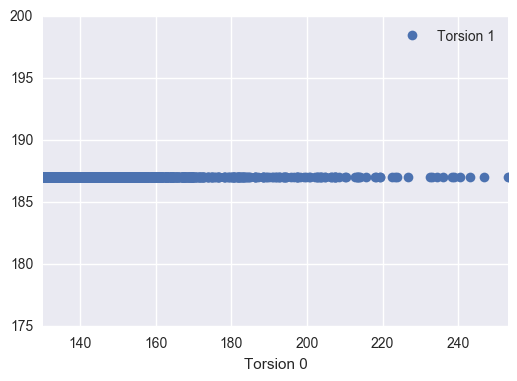

In [170]:
population = []
for i in range(population_size):
    mol_copy = deepcopy(mol)
    dihedrals = []
    
    for q, torsion in enumerate(mol_copy.torsions):
        dihedral = pop[i][q]
        dihedrals.append(dihedral)
        i,j,k,l = torsion.indices
        RHS = torsion.RHS
        
        mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)
    
    mol_copy.update_geometry_from_ase_mol()
    
    
    e = mol_copy.ase_molecule.get_potential_energy()
    
    population.append( [e] + dihedrals )
    
df = pd.DataFrame(population)
columns = ["Energy"]
for i in range(len(mol.torsion_list)):
    columns = columns +["Torsion " + str(i)] 
df.columns = columns
df = df.sort("Energy")
df.plot(x="Torsion 0", y="Torsion 1", style="o")

        

In [171]:
df

,Energy,Torsion 0,Torsion 1
5016,4.869014,130.156982,187.014565
1813,4.869014,130.156470,187.014565
4120,4.869014,130.166146,187.014565
9154,4.869022,130.187144,187.014565
6539,4.869024,130.190401,187.014565
5215,4.869046,130.101353,187.014565
9003,4.869055,130.094294,187.014565
4601,4.869061,130.227481,187.014565
3610,4.869067,130.231859,187.014565
1359,4.869079,130.239757,187.014565


In [172]:

tor0, tor1 = mol.torsions

for i, tor in enumerate(mol.torsions):
    dihedral = df.iloc[0][i+1]
    i,j,k,l = tor.indices
    RHS = tor.RHS
    mol.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(dihedral), 
                                    indices=RHS)
mol.view_mol()
    

In [189]:
for z in range(10): 
    print z
    a = np.zeros((2,2))
    mean = top.mean()[1:].reshape(1,2)
    print mean
    for i, value in enumerate(top.values):

        value = value[1:].reshape(1,2)
        a = a + (value - mean).T.dot((value - mean))

    pop = []
    for j in range(population_size):
        pop.append((mean + (std.dot(random.gauss(0, a/i)))/(np.abs(std.dot(random.gauss(0, a/i)))**1/2))[0])

    population = []
    for g in range(population_size):
        mol_copy = deepcopy(mol)
        dihedrals = []

        for q, torsion in enumerate(mol_copy.torsions):
            dihedral = pop[g][q]
            dihedrals.append(dihedral)
            i,j,k,l = torsion.indices
            RHS = torsion.RHS

            mol_copy.ase_molecule.set_dihedral(i,j,k,l, dihedral)

        mol_copy.update_geometry_from_ase_mol()


        e = mol_copy.ase_molecule.get_potential_energy()

        population.append( [e] + dihedrals )

    df = pd.DataFrame(population)
    columns = ["Energy"]
    for i in range(len(mol.torsion_list)):
        columns = columns +["Torsion " + str(i)] 
    df.columns = columns
    df = df.sort("Energy")
    #df.plot(x="Torsion 0", y="Torsion 1", style="o")

    top = df.iloc[:int(top_population),:]

0
[[ nan  nan]]


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1
[[ nan  nan]]
2
[[ nan  nan]]
3
[[ nan  nan]]
4
[[ nan  nan]]
5
[[ nan  nan]]


KeyboardInterrupt: 

In [182]:


for i, tor in enumerate(mol.torsions):
    dihedral = df.iloc[0][i+1]
    i,j,k,l = tor.indices
    RHS = tor.RHS
    mol.ase_molecule.set_dihedral(a1 = i,
                                    a2 = j, 
                                    a3 = k, 
                                    a4 = l, 
                                    angle= float(dihedral), 
                                    indices=RHS)
mol.view_mol()

In [186]:
mean

array([[ nan,  nan]])

In [ ]:

#mol.ase_molecule.set_calculator(calc)

# Getting the torsion combos
torsion_list = mol.torsions
torsion_angles = np.arange(0, 360,15) ### You can change the degree step size
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
if len(torsion_list) != 1:
    torsion_combos = list(
        set(
            torsion_combos + 
            list(itertools.combinations_with_replacement( 
                torsion_angles[::-1], len(torsion_list)
            ))))

    results = []
    
# Calculating the potential energy for each conformation
for combo in torsion_combos:
    geo = zip(torsion_list, combo)
    #print geo
    for torsion in geo:
        tor = torsion[0]
        #print tor
        angle = torsion[1]
        
        i,j,k,l = tor.indices
        RHS =  tor.RHS
        mol.ase_molecule.set_dihedral(a1 = i,
                                a2 = j, 
                                a3 = k, 
                                a4 = l, 
                                angle= float(angle), 
                                indices=RHS)
    mol.update_geometry_from_ase_mol()
    results.append([mol.ase_molecule.get_potential_energy()] + list(combo) )

# Creating a dataframe of the results
brute_force = pd.DataFrame(results)
columns = ["Energy"]
for i in range(len(torsion_list)):
    columns = columns + ["Torsion " + str(i)] 

brute_force.columns = columns
brute_force = brute_force.sort("Energy")
brute_force